## Извлечение 3D-тензоров левого и правого суставов из DICOM в автоматическом режиме

In [2]:
# Импортируем библиотеки
import os # функции операционной системы
import shutil # модуль с набором функций высокого уровня для обработки файлов, групп файлов и папок
import numpy as np # Работа с numpy-массивами
from PIL import Image # Отрисовка изображений
import matplotlib.pyplot as plt # Отрисовка графиков
import time # для расчета времени выполнения операций
from PIL import Image, ImageEnhance # Инструменты для работы с изображениями
from matplotlib.patches import Rectangle # рисование прямоугольников
import pydicom # для работы с DICOM-файлами
import pandas as pd # для работы с табличными данными
import re # работа с регулярными выражениями
import math # дополнительные математические функции
%matplotlib inline

In [3]:
#!pip install ultralytics==8.0.196
from IPython import display
display.clear_output()
import ultralytics
ultralytics.checks()
from ultralytics import YOLO

Ultralytics YOLOv8.0.196  Python-3.11.8 torch-2.2.1+cpu CPU (Intel Core(TM) i7-8565U 1.80GHz)
Setup complete  (8 CPUs, 15.9 GB RAM, 474.2/931.5 GB disk)


In [4]:
# Загрузка таблицы от Заказчика с патологиями, преобразованной в csv
data = pd.read_csv('D:\\Papa\\УИИ\\3-Стажировка 1\\03-dataset\\DATASET_DICOM\\patients2.csv', sep=';', usecols=['ID', 'Ф.И.О.', 'Диагноз (правый сустав)', 'Диагноз (левый сустав)'],  header=0, encoding='cp1251')
# "отфильтруем" список диагнозов
diags_list_left_tmp, diags_list_right_tmp = [], []
for i in range(len(data)):
    str_tmp_left = data.iloc[i]['Диагноз (левый сустав)'].replace(",", " ").replace("(+", " ").replace(" и ", " ").replace(")", " ").replace("гипоплазия", " ").replace("остеоартроз", " ").replace("киста", " ").replace("кисты", " ").replace("остеоартрит", " ").replace("положение", " ").replace("головки", " ").replace("сустава", " ").replace("субхондральная", " ").replace("ремоделирование", " ").lower()
    str_tmp_right = data.iloc[i]['Диагноз (правый сустав)'].replace(",", " ").replace("(+", " ").replace(" и ", " ").replace(")", " ").replace("гипоплазия", " ").replace("остеоартроз", " ").replace("киста", " ").replace("кисты", " ").replace("остеоартрит", " ").replace("положение", " ").replace("головки", " ").replace("сустава", " ").replace("субхондральная", " ").replace("ремоделирование", " ").lower()
    # Разделение строки на слова 
    words_list_left = str_tmp_left.split()
    words_list_right = str_tmp_right.split()
    diags_list_left_tmp = diags_list_left_tmp + words_list_left
    diags_list_right_tmp = diags_list_right_tmp + words_list_right
    # "переписываем" диагнозы
    data.loc[i, 'Диагноз (левый сустав)'] = words_list_left
    data.loc[i, 'Диагноз (правый сустав)'] = words_list_right
# исключим из списка кодов пациентов повторяющиеся
unique_list = list(set(diags_list_left_tmp))
diags_list_left_tmp = unique_list
# отсортируем список
diags_list_left_tmp.sort()
#print('Левые суставы:', diags_list_left_tmp)
# исключим из списка кодов пациентов повторяющиеся
unique_list = list(set(diags_list_right_tmp))
diags_list_right_tmp = unique_list
# отсортируем список
diags_list_right_tmp.sort()
#print('Правые суставы:', diags_list_right_tmp)
data.to_csv('D:\\Papa\\УИИ\\3-Стажировка 1\\03-dataset\\DATASET_DICOM\\patients2 (reformat).csv', encoding='cp1251', index=False)
data

,ID,Ф.И.О.,Диагноз (правый сустав),Диагноз (левый сустав)
0,К1,Останькович В.В.,[дистальное],[дистальное]
1,К2,Самойлова Е.Г. 29.12.2021,[дистальное],[дистальное]
2,К3,Авакимова М.Н.,"[дистальное, дистракция]","[центральное, латеральное]"
3,К4,Авдеева С.В.,[компрессия],[компрессия]
4,К5,Калинина З.П.,"[центральное, дистракция]",[дистальное]
...,...,...,...,...
424,К645,"Варнавская В,А. 05,03,24","[дистракция, дистальное]",[дистальное]
425,К646,"Кровякова М.А. 05,03024",[центральное],[центральное]
426,К648,Артемова О.А. 05.03.2024,[центральное],[дистракция]
427,К649,Вердова С.С,"[компрессия, дистальное]",[дистальное]


In [5]:
# Статистика по имеющемуся датасету в разрезе диагнозов
# Создание списка из элементов первой строки dataframe
row_list_left = data['Диагноз (левый сустав)'].values.tolist()
row_list_right = data['Диагноз (правый сустав)'].values.tolist()
diags_list = row_list_left + row_list_right 
# составим список уникальных значений диагнозов
unique_diags_list = list(set(str(diag) for diag in diags_list))
print('Количество комбинированных диагнозов (классов)', len(unique_diags_list))
print('Список комбинированных диагнозов:', unique_diags_list)

Количество комбинированных диагнозов (классов) 30
Список комбинированных диагнозов: ["['мезиальное', 'латеральное', 'компрессия']", "['латеральное', 'компрессия']", "['компрессия', 'центральное']", "['компрессия']", "['компрессия', 'мезиальное']", "['дистракция', 'латеральное']", "['центральное']", "['компрессия', 'мезиальное', 'латеральное']", "['дистальное', 'медиальное']", "['дистальное', 'компрессия']", "['мезиальное', 'компрессия']", "['мезиальное', 'медиальное']", "['дистальное', 'дистракция']", "['центральное', 'латеральное']", "['дистракция', 'мезиальное']", "['дистракция', 'дистальное', 'латеральное']", "['дистракция']", "['мезиальное']", "['дистальное']", "['компрессия', 'латеральное']", "['компрессия', 'дистальное']", "['компрессия', 'дистальное', 'латеральное']", "['медиальное', 'компрессия']", "['дистракция', 'дистальное']", "['дистальное', 'латеральное']", "['центральное', 'дистракция']", "['мезиальное', 'латеральное']", "['центральное', 'компрессия']", "['мезиальное', 'д

In [6]:
# Статистика по датасету в разрезе комбинированных диагнозов (классов)
# Объединение диагнозов из обеих колонок
diagnoses_left = data['Диагноз (левый сустав)'].tolist()
diagnoses_right = data['Диагноз (правый сустав)'].tolist()
all_diagnoses = diagnoses_left + diagnoses_right
# Подсчет количества уникальных диагнозов
diags_count = pd.Series(all_diagnoses).value_counts()
# Создание DataFrame с колонками 'Диагноз' и 'Кол-во, шт.'
diags_stat = pd.DataFrame({'Диагноз': diags_count.index, 'Кол-во суставов, шт.': diags_count.values})
# Преобразование диагнозов в формат, используемый в data
diags_stat['Диагноз'] = diags_stat['Диагноз'].astype(str)
# Добавление колонки 'ID' с соответствующими списками ID
id_lists = []
for diag in diags_stat['Диагноз']:
    id_list_left = data[data['Диагноз (левый сустав)'].astype(str) == diag]['ID'].tolist()
    id_list_right = data[data['Диагноз (правый сустав)'].astype(str) == diag]['ID'].tolist()
    id_lists.append(id_list_left + id_list_right)
diags_stat['ID'] = id_lists
# Запись в файл и вывод на экран
diags_stat.to_csv('D:\\Papa\\УИИ\\3-Стажировка 1\\03-dataset\\DATASET_DICOM\\_diags_stat.csv', encoding='cp1251', index=False)
diags_stat

,Диагноз,"Кол-во суставов, шт.",ID
0,['компрессия'],165,"[К4, К8, К16, К17, К18, К19, К21, К22, К28, К3..."
1,['дистальное'],133,"[К1, К2, К5, К11, К12, К26, К50, К51, К57, К64..."
2,['центральное'],114,"[К7, К9, К10, К13, К14, К23, К25, К29, К37, К4..."
3,"['компрессия', 'дистальное']",102,"[К44, К45, К46, К49, К52, К53, К55, К56, К58, ..."
4,"['дистальное', 'компрессия']",84,"[К15, К27, К32, К33, К68, К70, К81, К83, К86, ..."
5,['мезиальное'],71,"[К31, К38, К40, К41, К47, К60, К66, К72, К75, ..."
6,"['мезиальное', 'дистракция']",24,"[К6, К78, К82, К87, К89, К97, К115, К149, К155..."
7,"['компрессия', 'мезиальное']",24,"[К20, К128, К183, К237, К309, К569, К575, К579..."
8,"['мезиальное', 'компрессия']",23,"[К117, К130, К131, К139, К147, К152, К157, К31..."
9,"['центральное', 'компрессия']",18,"[К113, К132, К133, К165, К169, К81, К86, К88, ..."


In [7]:
# Создание списка "некомбинированных" диагнозов (классов) и сколько раз они встречаются
unique_diags_left = list(set(diags_list_left_tmp))
unique_diags_right = list(set(diags_list_right_tmp))
unique_diags = list(set(unique_diags_left + unique_diags_right))
unique_diags.sort()
# Создание DataFrame с колонками 'Диагноз' и 'Кол-во, шт.'
diags_stat_one = pd.DataFrame({'Диагноз': unique_diags})
# Добавление колонки 'Кол-во, шт.'
diags_count = []
for diag in unique_diags:
    count_left = sum(data['Диагноз (левый сустав)'].apply(lambda x: diag in x))
    count_right = sum(data['Диагноз (правый сустав)'].apply(lambda x: diag in x))
    diags_count.append(count_left + count_right)
diags_stat_one['Кол-во суставов, шт.'] = diags_count
# Добавление колонки 'ID' с соответствующими списками ID, где встречается такой диагноз
id_lists = []
for diag in unique_diags:
    id_list_left = data[data['Диагноз (левый сустав)'].apply(lambda x: diag in x)]['ID'].tolist()
    id_list_right = data[data['Диагноз (правый сустав)'].apply(lambda x: diag in x)]['ID'].tolist()
    id_lists.append(id_list_left + id_list_right)
diags_stat_one['ID'] = id_lists
# Вывод на экран
diags_stat_one.to_csv('D:\\Papa\\УИИ\\3-Стажировка 1\\03-dataset\\DATASET_DICOM\\_diags_stat_one.csv', encoding='cp1251', index=False)
diags_stat_one

,Диагноз,"Кол-во суставов, шт.",ID
0,дистальное,355,"[К1, К2, К5, К11, К12, К15, К26, К27, К32, К33..."
1,дистракция,84,"[К6, К24, К36, К61, К62, К63, К78, К82, К85, К..."
2,компрессия,438,"[К4, К8, К15, К16, К17, К18, К19, К20, К21, К2..."
3,латеральное,38,"[К3, К121, К122, К123, К124, К126, К127, К175,..."
4,медиальное,4,"[К250, К282, К252, К259]"
5,мезиальное,172,"[К6, К20, К31, К36, К38, К40, К41, К47, К60, К..."
6,центральное,140,"[К3, К7, К9, К10, К13, К14, К23, К25, К29, К37..."


### 1. Формирование списка DICOM-исследований

In [8]:
# определим список директорий с DICOM-исследованиями (содержат dcm-файлы)
WORK_DIR = "D:\\_ST_DATA\\"
# получим список всех вложенных файлов в директории
f_list = os.listdir(WORK_DIR)
# Указываем начальную директорию для поиска
start_dir = WORK_DIR
# Создаем пустой список для хранения директорий с файлами *.dcm
directories_with_dcm = []
# Просмотр всех поддиректорий
for root, dirs, files in os.walk(start_dir):
    for file in files:
        if file.endswith('.dcm'):
            directories_with_dcm.append(root)
# Удаляем дубликаты директорий, если таковые имеются
directories_with_dcm = list(set(directories_with_dcm))
directories_with_dcm.sort()
# Выводим список директорий, где содержатся DICOM-исследования
#for directory in directories_with_dcm:
#    print(directory)
print('\nКоличество DICOM-исследований:', len(directories_with_dcm))


Количество DICOM-исследований: 329


In [9]:
# Сбор данных из DICOM
# Функция извлечения из PATH кода исследования, присваимого Клиникой
def get_iD_clinic_from_path(path):
    # Разделение строки по символу "\"
    substrings = path.split('\\')
    # Получение подстроки, находящейся после последнего символа "\"
    return substrings[-1]

# Список (сведения о DICOM-исследовании)
db_study = []
# Просмотр папок с DICOM-исследованиями
for i, fol_K in enumerate(directories_with_dcm):
    # получим список dcm-файлов в текущей директории
    dicom_file_list = [file for file in os.listdir(fol_K) if file.endswith('.dcm')] 
    # сортировка списка по алфавиту
    dicom_file_list = sorted(dicom_file_list)
    # количество имеющихся аксиальных срезов в DICOM-исследовании
    axial_size = len(dicom_file_list)
    # читаем первый dcm-файл для извлечения из него нужных метаданных
    ds = pydicom.dcmread(fol_K + '\\' + dicom_file_list[0])
    # имя пациента
    patient_name = ds.PatientName
    patient_name = patient_name.decode('cp1251')
    # Тип медицинского оборудования (исследования)
    '''
    CR: Компьютерная радиография
    CT: Компьютерная томография
    MR: Магнитно-резонансная томография
    NM: Ядерная медицина
    OT: Другие типы медицинского оборудования
    PT: Положитронная эмиссионная томография
    US: Ультразвук
    XA: Рентгеновская ангиография
    '''
    modality = ds.Modality
    # Наименование оборудования
    ct_equipment_name = ds.get("ManufacturerModelName", "Нет информации")
    # Дата проведения исследования:
    study_date = ds.StudyDate[6:8] + '.' + ds.StudyDate[4:6] + '.' + ds.StudyDate[0:4]
    # количество сагиттальных срезов (ширина снимка в аксиальной проекции)
    sagittal_size = ds.Columns
    # количество корональных срезов (высота снимка в аксиальной проекции)
    coronal_size = ds.Rows
    # количество бит на пиксель
    bit_per_pixel = ds.BitsAllocated
    # Размер пикселя по горизонтали и вертикали на аксиальном срезе, мм
    pixel_spacing = ds.PixelSpacing
    # Толщина среза в трехмерном объеме данных, мм
    slice_thickness = ds.SliceThickness
    # Код исследования (пациента), присваемого Клиникой
    ID_clinic = get_iD_clinic_from_path(fol_K) 
    # дополним (для дополнительной сверки соответствия DICOM и таблицы диагнозов) поле Ф.И.О. пациента
    filtered_data = data[data['ID'] == ID_clinic]
    if not filtered_data.empty:
        patient_name = str(patient_name) + ' (' + filtered_data.iloc[0]['Ф.И.О.'] + ')'
    else:
    # Обработка случая, когда не найдено ни одной строки, удовлетворяющей условию
    # Например, можно присвоить пустую строку patient_name
        patient_name = str(patient_name)
        print('ВНИМАНИЕ: информация об исследовании ', ID_clinic, ' в таблице Заказчика отсутствует!')
    folder_name = fol_K 
    # установленные диагнозы для левого и правого суставов из таблицы Заказчика
    diags_left = data.iloc[data[data['ID'] == ID_clinic].index[0]]['Диагноз (левый сустав)']
    diags_right = data.iloc[data[data['ID'] == ID_clinic].index[0]]['Диагноз (правый сустав)']
    # Координаты расположения и размеры 3D-тензора левого и правого суставов в DICOM (начальная координата - точка "а")
    left_coord_ax, left_coord_cor, left_coord_sag = 0, 0, 0
    left_size_ax, left_size_cor, left_size_sag = 0, 0, 0
    right_coord_ax, right_coord_cor, right_coord_sag = 0, 0, 0
    right_size_ax, right_size_cor, right_size_sag = 0, 0, 0
    # Номера срезов в корональной и сагиттальной проекциях, определенных YOLO (внутри тензора с суставом)
    left_cor_slice, left_sag_slice = 0, 0
    right_cor_slice, right_sag_slice = 0, 0

    fol_study = [study_date, ID_clinic, patient_name, folder_name, modality, ct_equipment_name, axial_size, coronal_size, sagittal_size, bit_per_pixel, pixel_spacing, slice_thickness, 
                 diags_left, diags_right, left_coord_ax, left_coord_cor, left_coord_sag, left_size_ax, left_size_cor, left_size_sag, left_cor_slice, left_sag_slice,
                 right_coord_ax, right_coord_cor, right_coord_sag, right_size_ax, right_size_cor, right_size_sag, right_cor_slice, right_sag_slice]
    db_study.append(fol_study)
    print('{:03d}'.format(i), fol_study)
# Сохраним в csv
data_csv = pd.DataFrame(db_study, columns=['Дата исследования', 'ID', 'Пациент', 'Имя директории', 'Тип исследования', 'Оборудование', 'Размер (axial)', 'Размер (coronal)', 'Размер (sagittal)', 'Кол-во бит на пиксель', 
                                 'Размер пикселя, мм', 'Толщина аксиального среза, мм', 'Диагноз левого сустава', 'Диагноз правого сустава', 
                                 'LEFT_COORD_AX', 'LEFT_COORD_COR', 'LEFT_COORD_SAG', 'LEFT_SIZE_AX', 'LEFT_SIZE_COR', 'LEFT_SIZE_SAG', 'LEFT_COR_SLICE', 'LEFT_SAG_SLICE',
                                 'RIGHT_COORD_AX', 'RIGHT_COORD_COR', 'RIGHT_COORD_SAG', 'RIGHT_SIZE_AX', 'RIGHT_SIZE_COR', 'RIGHT_SIZE_SAG', 'RIGHT_COR_SLICE', 'RIGHT_SAG_SLICE'])
#data_csv.to_csv('D:\\Papa\\УИИ\\3-Стажировка 1\\03-dataset\\DATASET_DICOM\\_01_DB_PATIENT.csv', index=False, encoding='cp1251')

000 ['12.11.2023', 'К1', 'Останькович^Вячеслав Валерьевич (Останькович В.В.)', 'D:\\_ST_DATA\\К1', 'CT', 'PHT-60CFO', 760, 860, 860, 16, [0.200000, 0.200000], '0.2', ['дистальное'], ['дистальное'], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
001 ['17.11.2022', 'К10', 'ALEKHINA ELENA ALEKSANDROVNA (Алёхина Е.А. 17.11.2022)', 'D:\\_ST_DATA\\К10', 'CT', 'DENTRI-C', 723, 800, 800, 16, [0.20, 0.20], '0.2', ['центральное'], ['компрессия'], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
002 ['15.09.2023', 'К100', 'Кобзева^Софья Борисовна (Кобзева С.Б.15/09/23)', 'D:\\_ST_DATA\\К100', 'CT', 'PHT-60CFO', 760, 860, 860, 16, [0.200000, 0.200000], '0.2', ['дистальное', 'компрессия'], ['дистальное', 'компрессия'], 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
003 ['02.04.2023', 'К102', 'Созыкина^Екатерина Ивановна (Созыкина Е.С. 02.04.2023)', 'D:\\_ST_DATA\\К102', 'CT', 'PHT-60CFO', 760, 860, 860, 16, [0.200000, 0.200000], '0.2', ['дистальное', 'компрессия'], ['центральное', 'компрессия'], 0

In [10]:
print('Статистика мин/макс:')
print('Минимальное/максимальное количество аксиальных срезов в DICOM:', min(item[6] for item in db_study), '/', max(item[6] for item in db_study), 'шт.;')
print('Минимальное/максимальное разрешение снимка (axial slice): ', min(item[7] for item in db_study), '/', max(item[7] for item in db_study), 'пикселей;')
print('Минимальный/максимальный размер пикселя (толщина аксиального слоя):', min(item[11] for item in db_study), '/', max(item[11] for item in db_study), 'мм.')

Статистика мин/макс:
Минимальное/максимальное количество аксиальных срезов в DICOM: 407 / 1122 шт.;
Минимальное/максимальное разрешение снимка (axial slice):  468 / 1002 пикселей;
Минимальный/максимальный размер пикселя (толщина аксиального слоя): 0.120 / 1 мм.


In [11]:
# Формируем выборочную таблицу (dataframe) по имеющимся данным по каждому пациенту
PCODE, PAT_NAME, S_DATE = 'Код пациента', 'Ф.И.О.', 'Дата исследования'
df = pd.DataFrame(columns=[PCODE, PAT_NAME, S_DATE])
row = 1 # начинаем писать в таблицу с 1-ой строки
# заполняем таблицу
for fol_K in db_study: # по каждому пациенту
    # заполняем текущую строку
    df.at[row, PCODE]    = fol_K[1] # код пациента
    df.at[row, PAT_NAME] = fol_K[2] # Ф.И.О.
    df.at[row, S_DATE]   = fol_K[0] # дата исследования
    row += 1
df.to_csv('D:\\Papa\\УИИ\\3-Стажировка 1\\03-dataset\\DATASET_DICOM\\DB_PATIENT.csv', index=False, encoding='cp1251')

## 2. Извлечение 3D-тензоров с левым и правым суставами из DICOM

In [12]:
# Извлекаемые тензоры будут сохраняться в папку ORIG (размеры оригинальные, тип int16)
# (размеры извлекаемого тензора программно корректируются таким образом, чтобы в дальнейшем можно было пропорционально смасштабировать тензор к размеру 40х56х77, используя коэффициент масштабирования).
# Дополнительно тензоры будут сохраняться в папку SCALED в grayscale (0..255) в уменьшеном размере 40х56х77 пикселей (тип uint8). 
# Набор тензоров в папке SCALED - это будущий dataset для обучения ИНС на 3D-тензорах

SCALED_SAG_SIZE = 77     # размер тензора "в сагиттале"
K_COR_SCALED    = 1.375  # коэф. для расчета размера тензора в корональной проекции относительно размера в сагиттальной проекции (подобран опытным путем)
K_AX_SCALED     = 1.925  # коэф. для расчета размера тензора в аксиальной проекции (подобран опытным путем)
SCALED_COR_SIZE = SCALED_SAG_SIZE / K_COR_SCALED # размер тензора "в коронале" 77 / 1.375 = 56
SCALED_AX_SIZE  = SCALED_SAG_SIZE / K_AX_SCALED  # размер тензора "в аксиале" 77 / 1.925 = 40

In [13]:
# Функция определения нужного среза в DICOM с использованием YOLOv8
def get_slice(image_path, weights_file_path, conf=0.85, save=False):
    model = YOLO(weights_file_path) # модель YOLOv8n
    cur_time = time.time()  # Засекаем текущее время
    # запускаем predict YOLO
    results = model.predict(source=image_path, conf=conf, device=DEVICE, verbose=False, save=save)
    # проведем анализ результатов работы YOLO
    # инициализация переменных
    max_confidence = 0.0     # максиальный порог уверенности
    max_size = 0.0           # максимальная площадь bounding box'а
    selected_element = None  # номер среза
    #counter = 0              # счетчик подряд идущих изображений с имеющимися bounded box'ами
    x1, y1, x2, y2 = 0, 0, 0, 0
    conf_detected = 0.0
    num_slice_detected = -1
    for i, result in enumerate(results):
        # Проверяем, что есть обнаруженные объекты
        if result.boxes.xyxy.numel() > 0:
            # Итерируем по всем объектам и выбираем максимальный по порогу и размеру
            for j in range(result.boxes.xyxy.size(0)):
                confidence = result.boxes.conf[j]
                box_size = (result.boxes.xyxy[j, 2] - result.boxes.xyxy[j, 0]) * (result.boxes.xyxy[j, 3] - result.boxes.xyxy[j, 1])
                # Проверяем, если порог уверенности равен максимальному
                if confidence == max_confidence:
                    # Если размер bounding box'а больше, обновляем информацию
                    if box_size > max_size:
                        max_size = box_size
                        selected_element = (i, j)
                # Если порог уверенности больше максимального, обновляем информацию
                elif confidence > max_confidence:
                    max_confidence = confidence
                    max_size = box_size
                    selected_element = (i, j)
    # Выводим информацию о выбранном элементе
    if selected_element is not None:
        num_slice_detected, object_index = selected_element
        conf_detected = max_confidence
        # Итерируемся по bounding boxes и получаем координаты
        for box in results[num_slice_detected].boxes.xyxy:
             x1, y1, x2, y2 = box.tolist()
    else:
        num_slice_detected = -1 # срез не найден
    how_time = str(round(time.time() - cur_time, 2)) + ' c.'
    return results, num_slice_detected, conf_detected, x1, y1, x2, y2, how_time

In [14]:
# Отображение коронального среза
def show_cor_slice(num_slice, x1, y1, x2, y2):
    # Создайте фигуру и оси Matplotlib
    fig, ax = plt.subplots(1)
    # Отобразите изображение
    ax.imshow(dicom_in_3D_array[:,num_slice,:], cmap='gray')
    ax.axis('off')
    # добавление прямоугольника на аксиальном срезе (левый сустав)
    rect0 = Rectangle((x1, y1), abs(x2-x1), abs(y2-y1), edgecolor='red', facecolor='none')
    ax.add_patch(rect0)
    # Отобразите изображение с bounding boxes
    plt.show()

In [15]:
# Отображение сагиттального среза
def show_sag_slice(num_slice, x1, y1, x2, y2):
    # Создайте фигуру и оси Matplotlib
    fig, ax = plt.subplots(1)
    # Отобразите изображение
    ax.imshow(dicom_in_3D_array[:,:,num_slice], cmap='gray')
    ax.axis('off')
    # добавление прямоугольника на аксиальном срезе (левый сустав)
    rect0 = Rectangle((x1, y1), abs(x2-x1), abs(y2-y1), edgecolor='red', facecolor='none')
    ax.add_patch(rect0)
    # Отобразите изображение с bounding boxes
    plt.show()

In [16]:
# Функция масштабирования извлеченного 3-мерного тензора до размеров 40х56х77
def scale_tesor(mytensor):
    # Фактор сжатия (за основу берем "сагиттальный размер" тензора)
    compression_factor = mytensor.shape[2] / SCALED_SAG_SIZE
    # Размеры исходного тензора
    original_shape = mytensor.shape
    # Размеры масштабированного тензора
    scaled_shape = (int(original_shape[0] / compression_factor), 
                    int(original_shape[1] / compression_factor), 
                    int(original_shape[2] / compression_factor))
    # Создание пустого масштабированного тензора
    scaled_tensor = np.zeros(scaled_shape)
    # Масштабирование тензора без интерполяции
    for i in range(scaled_shape[0]):
        for j in range(scaled_shape[1]):
            for k in range(scaled_shape[2]):
                scaled_tensor[i, j, k] = mytensor[int(i * compression_factor),
                                                  int(j * compression_factor),
                                                  int(k * compression_factor)]
    sc_shape = (SCALED_AX_SIZE, SCALED_COR_SIZE, SCALED_SAG_SIZE)
    if scaled_shape != sc_shape:
        print('Оригинальный размер:', original_shape)
        print('Несоответствие размера тензора:', scaled_shape, '<>', sc_shape)
    return scaled_tensor

> извлекаемый 3D-тензор

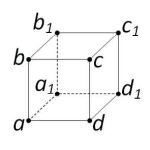 

Исследование 1 из 329: К536 от 14.02.2024 (Макарчук^София Сергеевна (Макарчук С.С.)):
- получен 3D тензор DICOM-исследования: (760, 860, 860) за 32.97 c;
- получены корональные срезы, шт.: L=517, R=517 за 1.79 c;
- координаты левого сустава: корональный срез 575, (x1, y1)=(622, 341), (x2, y2)=(770,409) получены за 47.3 c;
  диагноз специалиста (левый сустав): ['дистальное']


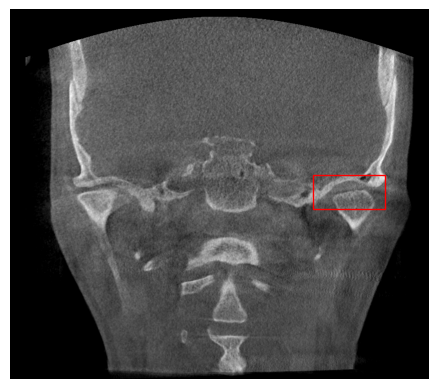

- координаты правого сустава: корональный срез 576, (x1, y1)=(120, 339), (x2, y2)=(288,409) получены за 43.28 c;
  диагноз специалиста (правый сустав): ['дистальное', 'компрессия']


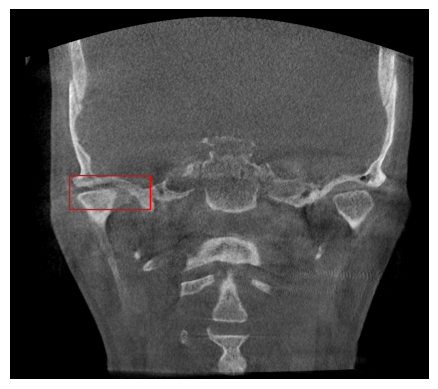

- получены сагиттальные срезы, шт.: L=430, R=430 за 4.04 c.

- координаты левого сустава: сагиттальный срез 732, (x1, y1)=(521, 349), (x2, y2)=(602,397) получены за 37.72 c;
  диагноз специалиста (левый сустав): ['дистальное']


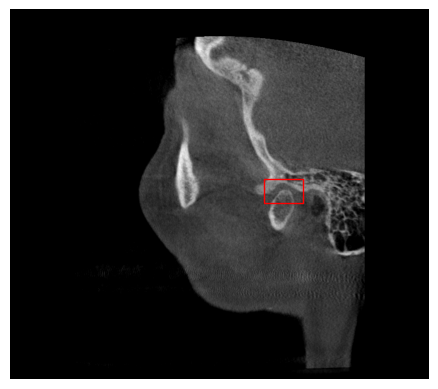

- координаты правого сустава: сагиттальный срез 215, (x1, y1)=(521, 346), (x2, y2)=(617,401) получены за 38.64 c;
  диагноз специалиста (правый сустав): ['дистальное', 'компрессия']


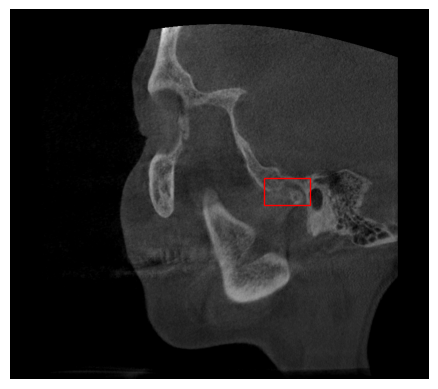

Координаты 3D-тензора с левым суставом: [349, 497, 598] , размер тензора: [102, 143, 196]
Координаты 3D-тензора с правым суставом: [346, 514, 96] , размер тензора: [113, 158, 216]
Обработка DICOM-исследования выполнена за 206.77 c.




In [17]:

COR_DIR_NAME = "cor"   # имя директории для хранения корональных срезов для левого и правого суставов (по картинках, находящимся в этой папке YOLO будет искать сустав и определять нужный номер среза)
SAG_DIR_NAME = "sag"   # имя директории для хранения сагиттальных срезов для левого и правого суставов (по картинках, находящимся в этой папке YOLO будет искать сустав и определять нужный номер среза)
LEFT_JOINT   = "left"  # имя поддиректории для храненения срезов левого сустава
RIGHT_JOINT  = "right" # имя поддиректории для храненения срезов правого сустава

TENSOR_DIR_NAME = "D:\\_ST_TENSORS\\"  # имя директории для хранения извлеченных из DICOM тензоров
ORIG_DIR_NAME = "ORIG"                 # имя поддиректории для хранения оригинальных тензоров
SCALED_DIR_NAME = "SCALED"             # имя поддиректории для храенения смасштабированных тензоров

# YOLO (YOLO обучена распознавать суставы на картинках размером 416x416)
WIDTH_YOLO   = 416     # ширина картинки
HEIGHT_YOLO  = 416     # высота картинки
DEVICE       = "cpu"   # GPU нет, работаю на CPU (((

indentation  = 120     # дополнительный отступ от левого края в сагиттальной проекции (смещение вправо отцентрированного изображения)

# "лучшие" веса YOLO
weights_file_path_cor = 'D:\\Papa\\УИИ\\3-Стажировка 1\\06-3d tensor\\04-Extract_tensors\\yolo_coronal\\best.pt'
weights_file_path_sag = 'D:\\Papa\\УИИ\\3-Стажировка 1\\06-3d tensor\\04-Extract_tensors\\yolo_sagittal\\best.pt'

# Просмотр папок с DICOM-исследованиями (смотрим из сформированного списка)
for index, fol_K in enumerate(db_study[241:242]):
    cur_time_dicom = time.time() # Засекаем время для расчета времени обработки одного DICOM-исследования
    cur_time = time.time()  # Засекаем текущее время
    print('Исследование '+ str(index + 1) + ' из ' + str(len(db_study)) + ': ' + str(fol_K[1]) + ' от ' + str(fol_K[0]) + ' (' + str(fol_K[2]) + '):')
    # создаем директории для генерируемых корональных срезов
    if os.path.exists(fol_K[3] + "\\" + COR_DIR_NAME): # если папка уже существует, удалим ее со всем содержимым
        shutil.rmtree(fol_K[3] + "\\" + COR_DIR_NAME)
    os.mkdir(fol_K[3] + "\\" + COR_DIR_NAME)
    os.mkdir(fol_K[3] + "\\" + COR_DIR_NAME + "\\" + LEFT_JOINT)
    os.mkdir(fol_K[3] + "\\" + COR_DIR_NAME + "\\" + RIGHT_JOINT)
    # создаем директории для генерируемых сагиттальных срезов
    if os.path.exists(fol_K[3] + "\\" + SAG_DIR_NAME): # если папка уже существует, удалим ее со всем содержимым
        shutil.rmtree(fol_K[3] + "\\" + SAG_DIR_NAME)
    os.mkdir(fol_K[3] + "\\" + SAG_DIR_NAME)
    os.mkdir(fol_K[3] + "\\" + SAG_DIR_NAME + "\\" + LEFT_JOINT)
    os.mkdir(fol_K[3] + "\\" + SAG_DIR_NAME + "\\" + RIGHT_JOINT)    
    # создаем 3D массив из DICOM-снимков текущего исследования
    dicom_in_3D_array = []
    dicom_orig_array = []
    # получим список dcm-файлов в текущей директории
    dicom_file_list = [file for file in os.listdir(fol_K[3]) if file.endswith('.dcm')] 
    # сортировка списка по алфавиту
    dicom_file_list = sorted(dicom_file_list)
    # последовательно читаем аксиальные срезы
    for fol_axial_slice in dicom_file_list:
        img = pydicom.read_file(fol_K[3] + '\\' + fol_axial_slice).pixel_array.astype('int16')
        # добавляем текущий срез в 3D массив
        dicom_in_3D_array.append(img)
        dicom_orig_array.append(img)
    # преобразование в numpy-массив
    dicom_orig_array = np.array(dicom_orig_array, dtype='int16') # оригинальный DICOM без преобразований
    dicom_in_3D_array = np.array(dicom_in_3D_array, dtype='float32')
    # Определяем минимальное и максимальное значение в массиве
    min_value = np.min(dicom_in_3D_array)
    max_value = np.max(dicom_in_3D_array)
    # Приводим к диапазону 0 ... 255
    dicom_in_3D_array = 255 * (dicom_in_3D_array - min_value) / (max_value - min_value)
    # Округление значений до целых чисел
    dicom_in_3D_array = np.round(dicom_in_3D_array).astype(np.uint8)
    print('- получен 3D тензор DICOM-исследования: ' + str(dicom_in_3D_array.shape) + ' за ' + str(round(time.time() - cur_time, 2)) + ' c;')
    cur_time = time.time()  # Засекаем текущее время
    # генерация срезов в корональной проекции из полученного 3D массива
    # Левый сустав:
    L_st = int(fol_K[7] * 0.2) # с какого среза начинаем нарезать 
    L_how = int(fol_K[7] - L_st * 2) # количество срезов
    # Правый сустав:
    R_st = int(fol_K[7] * 0.2) # с какого среза начинаем нарезать 
    R_how = int(fol_K[7] - R_st * 2) # количество срезов
    L_slice_how, R_slice_how = 0, 0    
    for i in range(fol_K[7]): # coronal_size
        if ((i >= L_st) and (i <= L_st + L_how)) or ((i >= R_st) and (i <= R_st + R_how)):
            # вычисляем координаты вырезаемого квадрата на корональном срезе, где должен присутствовать левый сустав (отцентрован по вертикали и примыкает к правому краю изображения)
            # левый сустав содержится в правой половине изображения
            x_start = fol_K[8] - WIDTH_YOLO # fol_K[7] // 2
            if fol_K[8] < WIDTH_YOLO: # если ширина окна менее 416 (WIDTH_YOLO)
                x_start = 0
                x_len = fol_K[8]
            else: # если более
                x_len = WIDTH_YOLO
            y_start = (fol_K[6] - HEIGHT_YOLO) // 2
            # создаем "пустое" (черное) изображение-заготовку
            img_416 = np.zeros((WIDTH_YOLO, HEIGHT_YOLO))
            if fol_K[6] < HEIGHT_YOLO: # если количество аксиальных срезов в DICOM-исследовании меньше 416, то вписываем корональный срез в заготовку
                y_st_416 = 0 #(HEIGHT_YOLO - fol_K[5]) // 2
                img_416[y_st_416:y_st_416 + fol_K[6],:x_len] = dicom_in_3D_array[:, i, x_start:x_start + x_len]
            else:
                img_416[:,:x_len] = dicom_in_3D_array[y_start:y_start + HEIGHT_YOLO, i, x_start:x_start + x_len]
            img_416 = img_416.astype(np.uint8)
            # Создание объекта изображения PIL
            image_pil = Image.fromarray(img_416) 
            # Сохранение изображения в формате JPG (для YOLO)
            image_pil.save(fol_K[3] + '\\' + COR_DIR_NAME + '\\' + LEFT_JOINT + '\\' + 'l_cor_' + f'{i:04d}' + fol_K[1] + '.jpg') # '.png')
            L_slice_how += 1
            # правый сустав содержится в левой половине изображения
            # для получения левой половины изображения отзеркалим изображение, его в последствии и будем подавать в YOLO
            flipped_slice = dicom_in_3D_array[:, i, :]
            flipped_slice = flipped_slice[:,::-1]

            x_start = fol_K[8] - WIDTH_YOLO 
            if fol_K[8] < WIDTH_YOLO: # если ширина окна менее 416 (WIDTH_YOLO)
                x_start = 0
                x_len = fol_K[7]
            else: # если более
                x_len = WIDTH_YOLO
            y_start = (fol_K[6] - HEIGHT_YOLO) // 2
            # создаем "пустое" (черное) изображение-заготовку
            img_416 = np.zeros((WIDTH_YOLO, HEIGHT_YOLO))
            if fol_K[6] < HEIGHT_YOLO: # если количество аксиальных срезов в DICOM-исследовании меньше 416, то вписываем корональный срез в заготовку
                y_st_416 = 0 
                img_416[y_st_416:y_st_416 + fol_K[6],:x_len] = flipped_slice[:, x_start:x_start + x_len]
            else:
                img_416[:,:x_len] = flipped_slice[y_start:y_start + HEIGHT_YOLO, x_start:x_start + x_len]
            img_416 = img_416.astype(np.uint8)
            # Создание объекта изображения PIL
            image_pil = Image.fromarray(img_416) 

            # Сохранение изображения в формате JPG (для YOLO)
            image_pil.save(fol_K[3] + '\\' + COR_DIR_NAME + '\\' + RIGHT_JOINT + '\\' + 'r_cor_' + f'{i:04d}' + fol_K[1] + '.jpg') #'.png')
            R_slice_how += 1
    print('- получены корональные срезы, шт.: L=' + str(L_slice_how) + ', R=' + str(R_slice_how) + ' за ' + str(round(time.time() - cur_time, 2)) + ' c;')
 
    # ЛЕВЫЙ СУСТАВ
    cur_time = time.time()  # Засекаем текущее время
    # выполним поиск нужного среза на полученных корональных проекциях для левого сустава
    
    results, num_slice_detected, conf_detected, x1, y1, x2, y2, how_time = get_slice(fol_K[3] + '\\' + COR_DIR_NAME + '\\' + LEFT_JOINT, weights_file_path_cor, conf=0.85, save=False)
    if num_slice_detected < 0:
        left_a_cor_x_sag, left_a_cor_y_ax, left_b_cor_x_sag, left_b_cor_y_ax, left_c_cor_x_sag, left_c_cor_y_ax, left_d_cor_x_sag, left_d_cor_y_ax = 0, 0, 0, 0, 0, 0, 0, 0
        print('\033[91mВНИМАНИЕ: ЛЕВЫЙ СУСТАВ В КОРОНАЛЬНОЙ ПРОЕКЦИИ НЕ ОБНАРУЖЕН.\033[0m')
    else:
        # левый сустав: координаты прямоугольника abcd (корональный срез):
        left_a_cor_x_sag = int(fol_K[8] - WIDTH_YOLO + x1)
        left_a_cor_y_ax  = int((fol_K[6] - HEIGHT_YOLO) // 2 + y2)
        left_b_cor_x_sag = int(left_a_cor_x_sag)
        left_b_cor_y_ax  = int((fol_K[6] - HEIGHT_YOLO) // 2 + y1)
        left_c_cor_x_sag = int((fol_K[8] - WIDTH_YOLO) + x2)
        left_c_cor_y_ax  = left_b_cor_y_ax
        left_d_cor_x_sag = left_c_cor_x_sag
        left_d_cor_y_ax  = left_a_cor_y_ax
        print('- координаты левого сустава: корональный срез ' + str(num_slice_detected + L_st) + ', (x1, y1)=(' + str(left_b_cor_x_sag) + ', ' + str(left_b_cor_y_ax) + '), (x2, y2)=('
              + str(left_d_cor_x_sag) + ',' + str(left_d_cor_y_ax)+') получены за ' + str(round(time.time() - cur_time, 2)) + ' c;')
        print('  диагноз специалиста (левый сустав):', fol_K[12])
        # отобразим левый сустав
        show_cor_slice(num_slice_detected + L_st, left_b_cor_x_sag, left_b_cor_y_ax, left_d_cor_x_sag, left_d_cor_y_ax)

    # ПРАВЫЙ СУСТАВ
    cur_time = time.time()  # Засекаем текущее время
    # выполним поиск нужного среза на полученных корональных проекциях для правого сустава
    results, num_slice_detected, conf_detected, x1, y1, x2, y2, how_time = get_slice(fol_K[3] + '\\' + COR_DIR_NAME + '\\' + RIGHT_JOINT, weights_file_path_cor, conf=0.85, save=False)
    if num_slice_detected < 0:
        right_a_cor_x_sag, right_a_cor_y_ax, right_b_cor_x_sag, right_b_cor_y_ax, right_c_cor_x_sag, right_c_cor_y_ax, right_d_cor_x_sag, right_d_cor_y_ax = 0, 0, 0, 0, 0, 0, 0, 0
        print('\033[91mВНИМАНИЕ: ПРАВЫЙ СУСТАВ В КОРОНАЛЬНОЙ ПРОЕКЦИИ НЕ ОБНАРУЖЕН.\033[0m')
    else: 
        # правый сустав: координаты прямоугольника abcd (корональный срез):
        right_a_cor_x_sag = int(fol_K[8] - ((fol_K[8] - WIDTH_YOLO) + x2))
        right_a_cor_y_ax  = int((fol_K[6] - HEIGHT_YOLO) // 2 + y2)
        right_b_cor_x_sag = right_a_cor_x_sag
        right_b_cor_y_ax  = int((fol_K[6] - HEIGHT_YOLO) // 2 + y1)
        right_c_cor_x_sag = int(fol_K[8] - (fol_K[8] - WIDTH_YOLO + x1))
        right_c_cor_y_ax  = right_b_cor_y_ax
        right_d_cor_x_sag = right_c_cor_x_sag
        right_d_cor_y_ax  = right_a_cor_y_ax
        print('- координаты правого сустава: корональный срез ' + str(num_slice_detected + L_st) + ', (x1, y1)=(' + str(right_b_cor_x_sag) + ', ' + str(right_b_cor_y_ax) + '), (x2, y2)=('
            + str(right_d_cor_x_sag) + ',' + str(right_d_cor_y_ax)+') получены за ' + str(round(time.time() - cur_time, 2)) + ' c;')
        print('  диагноз специалиста (правый сустав):', fol_K[13])
        # отобразим правый сустав
        show_cor_slice(num_slice_detected + L_st, right_b_cor_x_sag, right_b_cor_y_ax, right_d_cor_x_sag, right_d_cor_y_ax)
    cur_time = time.time()  # Засекаем текущее время
    # генерация срезов в сагиттальной проекции из полученного 3D массива
    indent = indentation
    if (fol_K[7] // 2 - WIDTH_YOLO // 2 + indentation + WIDTH_YOLO) > fol_K[6]:
        indent = fol_K[6] - (fol_K[7] // 2 - WIDTH_YOLO // 2 + WIDTH_YOLO)
    # Левый сустав:
    L_st = fol_K[8] // 2 
    L_how = fol_K[8] - L_st 
    # Правый сустав:
    R_st = 0 
    R_how = fol_K[8] // 2 
    L_slice_how, R_slice_how = 0, 0
    for i in range(fol_K[8]): # sagittal_size
        if ((i >= L_st) and (i <= L_st + L_how)) or ((i >= R_st) and (i <= R_st + R_how)):
            # вычисляем координаты вырезаемого квадрата (окна) на сагиттальном срезе, где должен присутствовать сустав (отцентрован по вертикали и по горизонтали относительно всей сагиттальной проекции)
            x_start = fol_K[7] // 2 - WIDTH_YOLO // 2 + indent # центруем окно по горизонтали и смещаем вправо
            y_start = (fol_K[6] - HEIGHT_YOLO) // 2   # центруем окно по вертикали
            # создаем "пустое" (черное) изображение-заготовку
            img_416 = np.zeros((WIDTH_YOLO, HEIGHT_YOLO))
            if fol_K[6] < HEIGHT_YOLO: # если количество аксиальных срезов в DICOM-исследовании меньше 416, то вписываем сагиттальный срез в заготовку, центрируя по вертикали
                y_st_416 = (HEIGHT_YOLO - fol_K[6]) // 2
                img_416[y_st_416:y_st_416 + fol_K[6],:] = dicom_in_3D_array[:, x_start:x_start + WIDTH_YOLO, i]
            else:
                img_416[:,:] = dicom_in_3D_array[y_start:y_start + HEIGHT_YOLO, x_start:x_start + WIDTH_YOLO, i]
            img_416 = img_416.astype(np.uint8)
            # Создание объекта изображения PIL
            image_pil = Image.fromarray(img_416)

            # Сохранение изображения в формате JPG (для YOLO)
            if (i >= L_st) and (i <= L_st + L_how): # левый сустав
                image_pil.save(fol_K[3] + '\\' + SAG_DIR_NAME + '\\' + LEFT_JOINT + '\\' + 'l_sag_' + f'{i:04d}' + '_' + fol_K[1] + '.jpg') #'.png')
                L_slice_how += 1
            else: # правый сустав
                image_pil.save(fol_K[3] + '\\' + SAG_DIR_NAME + '\\' + RIGHT_JOINT + '\\' + 'r_sag_' + f'{i:04d}' + '_' + fol_K[1] + '.jpg') #'.png')
                R_slice_how += 1
    print('- получены сагиттальные срезы, шт.: L=' + str(L_slice_how) + ', R=' + str(R_slice_how) + ' за ' + str(round(time.time() - cur_time, 2)) + ' c.\n')

    # ЛЕВЫЙ СУСТАВ
    cur_time = time.time()  # Засекаем текущее время
    # выполним поиск нужного среза на полученных корональных проекциях для левого сустава
    
    results, num_slice_detected, conf_detected, x1, y1, x2, y2, how_time = get_slice(fol_K[3] + '\\' + SAG_DIR_NAME + '\\' + LEFT_JOINT, weights_file_path_sag, conf=0.65, save=False)
    if num_slice_detected < 0:
        left_a_sag_x_cor, left_a_sag_y_ax, left_b_sag_x_cor, left_b_sag_y_ax, left_b1_sag_x_cor, left_b1_sag_y_ax, left_a1_sag_x_cor, left_a1_sag_y_ax = 0, 0, 0, 0, 0, 0, 0, 0
        print('\033[91mВНИМАНИЕ: ЛЕВЫЙ СУСТАВ В САГИТТАЛЬНОЙ ПРОЕКЦИИ НЕ ОБНАРУЖЕН.\033[0m')
    else:
        # левый сустав: координаты прямоугольника abb1a1 (сагиттальный срез):
        left_a_sag_x_cor  = int(fol_K[7] // 2 - WIDTH_YOLO // 2 + x1 + indent)
        left_a_sag_y_ax   = int(((fol_K[6] - HEIGHT_YOLO) // 2) + y2)
        left_b_sag_x_cor  = left_a_sag_x_cor
        left_b_sag_y_ax   = int((fol_K[6] - HEIGHT_YOLO) // 2 + y1)
        left_b1_sag_x_cor = int(fol_K[7] // 2 - WIDTH_YOLO // 2 + x2 + indent)
        left_b1_sag_y_ax  = left_b_sag_y_ax
        left_a1_sag_x_cor = left_b1_sag_x_cor
        left_a1_sag_y_ax  = left_a_sag_y_ax 
        print('- координаты левого сустава: сагиттальный срез ' + str(num_slice_detected + L_st) + ', (x1, y1)=(' + str(left_b_sag_x_cor) + ', ' + str(left_b_sag_y_ax) + '), (x2, y2)=('
            + str(left_a1_sag_x_cor) + ',' + str(left_a1_sag_y_ax)+') получены за ' + str(round(time.time() - cur_time, 2)) + ' c;')
        print('  диагноз специалиста (левый сустав):', fol_K[12])
        # отобразим левый сустав
        show_sag_slice(num_slice_detected + L_st, left_b_sag_x_cor, left_b_sag_y_ax, left_a1_sag_x_cor, left_a1_sag_y_ax)

    # ПРАВЫЙ СУСТАВ
    cur_time = time.time()  # Засекаем текущее время
    # выполним поиск нужного среза на полученных корональных проекциях для правого сустава
    results, num_slice_detected, conf_detected, x1, y1, x2, y2, how_time = get_slice(fol_K[3] + '\\' + SAG_DIR_NAME + '\\' + RIGHT_JOINT, weights_file_path_sag, conf=0.65, save=False)
    if num_slice_detected < 0:
        right_a_sag_x_cor, right_a_sag_y_ax, right_b_sag_x_cor, right_b_sag_y_ax, right_b1_sag_x_cor, right_b1_sag_y_ax, right_a1_sag_x_cor, right_a1_sag_y_ax = 0, 0, 0, 0, 0, 0, 0, 0
        print('\033[91mВНИМАНИЕ: ПРАВЫЙ СУСТАВ В САГИТТАЛЬНОЙ ПРОЕКЦИИ НЕ ОБНАРУЖЕН.\033[0m')
    else:
        # правый сустав: координаты прямоугольника abb1a1 (сагиттальный срез):
        right_a_sag_x_cor  = int(fol_K[7] // 2 - WIDTH_YOLO // 2 + x1 + indent)
        right_a_sag_y_ax   = int(((fol_K[6] - HEIGHT_YOLO) // 2) + y2)
        right_b_sag_x_cor  = left_a_sag_x_cor
        right_b_sag_y_ax   = int((fol_K[6] - HEIGHT_YOLO) // 2 + y1)
        right_b1_sag_x_cor = int(fol_K[7] // 2 - WIDTH_YOLO // 2 + x2 + indent)
        right_b1_sag_y_ax  = right_b_sag_y_ax
        right_a1_sag_x_cor = right_b1_sag_x_cor
        right_a1_sag_y_ax  = right_a_sag_y_ax
        print('- координаты правого сустава: сагиттальный срез ' + str(num_slice_detected + R_st) + ', (x1, y1)=(' + str(right_b_sag_x_cor) + ', ' + str(right_b_sag_y_ax) + '), (x2, y2)=('
            + str(right_a1_sag_x_cor) + ',' + str(right_a1_sag_y_ax)+') получены за ' + str(round(time.time() - cur_time, 2)) + ' c;')
        print('  диагноз специалиста (правый сустав):', fol_K[13])
        # отобразим правый сустав
        show_sag_slice(num_slice_detected + R_st, right_b_sag_x_cor, right_b_sag_y_ax, right_a1_sag_x_cor, right_a1_sag_y_ax)
   
    # определим итоговые размеры 3D тензеров с суставами:
    # левый сустав:
    # верхняя граница тензора
    if left_b_cor_y_ax > left_b_sag_y_ax:
        left_b_sag_y_ax  = left_b_cor_y_ax
        left_b1_sag_y_ax = left_b_cor_y_ax
    else:
        left_b_cor_y_ax  = left_b_sag_y_ax
        left_c_cor_y_ax  = left_b_sag_y_ax
    # нижняя граница тензора
    if left_a_cor_y_ax < left_a_sag_y_ax:
        left_a_sag_y_ax  = left_a_cor_y_ax
        left_a1_sag_y_ax = left_a_cor_y_ax
    else:
        left_a_cor_y_ax  = left_a_sag_y_ax
        left_d_cor_y_ax  = left_a_sag_y_ax
    
    # правый сустав:
    # верхняя граница тензора
    if right_b_cor_y_ax > right_b_sag_y_ax:
        right_b_sag_y_ax  = right_b_cor_y_ax
        right_b1_sag_y_ax = right_b_cor_y_ax
    else:
        right_b_cor_y_ax  = right_b_sag_y_ax
        right_c_cor_y_ax  = right_b_sag_y_ax
    # нижняя граница тензора
    if right_a_cor_y_ax < right_a_sag_y_ax:
        right_a_sag_y_ax  = right_a_cor_y_ax
        right_a1_sag_y_ax = right_a_cor_y_ax
    else:
        right_a_cor_y_ax  = right_a_sag_y_ax
        right_d_cor_y_ax  = right_a_sag_y_ax

    # Ручная корректировка размера тензора в пикселях (расширение границ)
    ADD_SIZE = 48

    # координаты вершин тензора с левым суставом [Ax, Cor, Sag]:
    left_a  = [left_b_cor_y_ax, left_a_sag_x_cor - ADD_SIZE // 2,  left_a_cor_x_sag - ADD_SIZE // 2]
    left_b  = [left_a_cor_y_ax, left_b_sag_x_cor - ADD_SIZE // 2,  left_b_cor_x_sag - ADD_SIZE // 2]
    left_c  = [left_d_cor_y_ax, left_b_sag_x_cor + ADD_SIZE // 2,  left_c_cor_x_sag + ADD_SIZE // 2]
    left_d  = [left_c_cor_y_ax, left_a_sag_x_cor + ADD_SIZE // 2,  left_d_cor_x_sag + ADD_SIZE // 2]
    left_a1 = [left_b_cor_y_ax, left_a1_sag_x_cor - ADD_SIZE // 2, left_a_cor_x_sag - ADD_SIZE // 2]
    left_b1 = [left_a_cor_y_ax, left_b1_sag_x_cor - ADD_SIZE // 2, left_b_cor_x_sag - ADD_SIZE // 2]
    left_c1 = [left_d_cor_y_ax, left_b1_sag_x_cor + ADD_SIZE // 2, left_c_cor_x_sag + ADD_SIZE // 2]
    left_d1 = [left_c_cor_y_ax, left_a1_sag_x_cor + ADD_SIZE // 2, left_d_cor_x_sag + ADD_SIZE // 2]

    # координаты вершин тензора с правым суставом [Ax, Cor, Sag]:
    right_a  = [right_b_cor_y_ax, right_a_sag_x_cor - ADD_SIZE // 2,  right_a_cor_x_sag - ADD_SIZE // 2]
    right_b  = [right_a_cor_y_ax, right_b_sag_x_cor - ADD_SIZE // 2,  right_b_cor_x_sag - ADD_SIZE // 2]
    right_c  = [right_d_cor_y_ax, right_b_sag_x_cor + ADD_SIZE // 2,  right_c_cor_x_sag + ADD_SIZE // 2]
    right_d  = [right_c_cor_y_ax, right_a_sag_x_cor + ADD_SIZE // 2,  right_d_cor_x_sag + ADD_SIZE // 2]
    right_a1 = [right_b_cor_y_ax, right_a1_sag_x_cor - ADD_SIZE // 2, right_a_cor_x_sag - ADD_SIZE // 2]
    right_b1 = [right_a_cor_y_ax, right_b1_sag_x_cor - ADD_SIZE // 2, right_b_cor_x_sag - ADD_SIZE // 2]
    right_c1 = [right_d_cor_y_ax, right_b1_sag_x_cor + ADD_SIZE // 2, right_c_cor_x_sag + ADD_SIZE // 2]
    right_d1 = [right_c_cor_y_ax, right_a1_sag_x_cor + ADD_SIZE // 2, right_d_cor_x_sag + ADD_SIZE // 2]

    # определим размеры тензора с левым суставом [Ax, Cor, Sag]
    # left_tensor_size = [abs(left_b[0] - left_a[0]),
    #                     abs(left_b1[1] - left_b[1]),
    #                     abs(left_a[2] - left_d[2])]
    tmp_sag_size = abs(left_a[2] - left_d[2])
    # определим коэффициент масштабирования
    K_SAG_SCALED = tmp_sag_size / SCALED_SAG_SIZE
    # вычисляем скорректированный "сагиттальный размер" тензора
    tmp_sag_size = math.ceil(K_SAG_SCALED * SCALED_SAG_SIZE)
    # вычислим скорректированный "корональный размер" тензора
    tmp_cor_size = math.ceil(tmp_sag_size / K_COR_SCALED)
    # вычислим скорректированный "аксиальный размер" тензора
    tmp_ax_size  = math.ceil(tmp_sag_size / K_AX_SCALED)
    # размеры тензора, содержащего левый сустав:
    left_tensor_size = [tmp_ax_size, tmp_cor_size, tmp_sag_size]
    
    # размеры тензора с правым суставом [Ax, Cor, Sag]
    # right_tensor_size = [abs(right_b[0] - right_a[0]),
    #                     abs(right_b1[1] - right_b[1]),
    #                     abs(right_a[2] - right_d[2])]
    tmp_sag_size = abs(right_a[2] - right_d[2])
    # определим коэффициент масштабирования
    K_SAG_SCALED = tmp_sag_size / SCALED_SAG_SIZE
    # вычисляем скорректированный "сагиттальный размер" тензора
    tmp_sag_size = math.ceil(K_SAG_SCALED * SCALED_SAG_SIZE)
    # вычислим скорректированный "корональный размер" тензора
    tmp_cor_size = math.ceil(tmp_sag_size / K_COR_SCALED)
    # вычислим скорректированный "аксиальный размер" тензора
    tmp_ax_size  = math.ceil(tmp_sag_size / K_AX_SCALED)
    # размеры тензора, содержащего правый сустав:
    right_tensor_size = [tmp_ax_size, tmp_cor_size, tmp_sag_size]
    
    print('Координаты 3D-тензора с левым суставом:', left_a, ', размер тензора:', left_tensor_size)
    print('Координаты 3D-тензора с правым суставом:', right_a, ', размер тензора:', right_tensor_size)
        
    # записываем данные по левому суставу
    fol_K[14:17] = left_a
    fol_K[17:20] = left_tensor_size
    # записываем данные по правому суставу
    fol_K[22:25] = right_a
    fol_K[25:28] = right_tensor_size

    # Вырезаем тензоры из DICOM и сохраняем в файлы (в папку ORIG\ тензоры с оригинальными размерами и цветом пикселей; в SCALED - преобразованные тензора (смаштабированные к 40х56х77 в grayscale 0-255))
    # ЛЕВЫЙ ТЕНЗОР
    left_start_coords = left_a

    left_tensor = dicom_orig_array[left_start_coords[0]:left_start_coords[0] + left_tensor_size[0],
                                   left_start_coords[1]:left_start_coords[1] + left_tensor_size[1],
                                   left_start_coords[2]:left_start_coords[2] + left_tensor_size[2]]

    # запись тензора (3-мерный numpy-массив) в папку ORIG
    np.save(TENSOR_DIR_NAME + ORIG_DIR_NAME + '\\' + 'Л' + fol_K[1], left_tensor.astype(np.int16), allow_pickle=True)

    # Выполним масштабирование тензора 
    # извлекаем тензор из нормированного 3D-массива DICOM
    left_tensor = dicom_in_3D_array[left_start_coords[0]:left_start_coords[0] + left_tensor_size[0],
                                    left_start_coords[1]:left_start_coords[1] + left_tensor_size[1],
                                    left_start_coords[2]:left_start_coords[2] + left_tensor_size[2]]
    # масштабирование
    scaled_left_tensor = scale_tesor(left_tensor)

    # запись тензора (3-мерный numpy-массив) в папку SCALED
    np.save(TENSOR_DIR_NAME + SCALED_DIR_NAME + '\\' + 'Л' + fol_K[1], scaled_left_tensor.astype(np.uint8), allow_pickle=True)

    # ПРАВЫЙ ТЕНЗОР:
    right_start_coords = right_a

    right_tensor = dicom_orig_array[right_start_coords[0]:right_start_coords[0] + right_tensor_size[0],
                                    right_start_coords[1]:right_start_coords[1] + right_tensor_size[1],
                                    right_start_coords[2]:right_start_coords[2] + right_tensor_size[2]]
    
    right_tensor = np.flip(right_tensor, axis=2) # отзеркалим тензор по горизонтали

    np.save(TENSOR_DIR_NAME + ORIG_DIR_NAME + '\\' + 'П' + fol_K[1], right_tensor.astype(np.int16), allow_pickle=True)

    # Выполним масштабирование тензора 
    # извлекаем тензор из нормированного 3D-массива DICOM
    right_tensor = dicom_in_3D_array[right_start_coords[0]:right_start_coords[0] + right_tensor_size[0],
                                    right_start_coords[1]:right_start_coords[1] + right_tensor_size[1],
                                    right_start_coords[2]:right_start_coords[2] + right_tensor_size[2]]
    # масштабирование
    scaled_right_tensor = scale_tesor(right_tensor)

    scaled_right_tensor = np.flip(scaled_right_tensor, axis=2) # отзеркалим тензор по горизонтали
    # запись тензора (3-мерный numpy-массив) в папку SCALED
    np.save(TENSOR_DIR_NAME + SCALED_DIR_NAME + '\\' + 'П' + fol_K[1], scaled_right_tensor.astype(np.uint8), allow_pickle=True)

    print('Обработка DICOM-исследования выполнена за ' + str(round(time.time() - cur_time_dicom, 2)) + ' c.\n\n')

# Сохраним в csv
data_csv = pd.DataFrame(db_study, columns=['Дата исследования', 'ID', 'Пациент', 'Имя директории', 'Тип исследования', 'Оборудование', 'Размер (axial)', 'Размер (coronal)', 'Размер (sagittal)', 'Кол-во бит на пиксель', 
                                 'Размер пикселя, мм', 'Толщина аксиального среза, мм', 'Диагноз левого сустава', 'Диагноз правого сустава', 
                                 'LEFT_COORD_AX', 'LEFT_COORD_COR', 'LEFT_COORD_SAG', 'LEFT_SIZE_AX', 'LEFT_SIZE_COR', 'LEFT_SIZE_SAG', 'LEFT_COR_SLICE', 'LEFT_SAG_SLICE',
                                 'RIGHT_COORD_AX', 'RIGHT_COORD_COR', 'RIGHT_COORD_SAG', 'RIGHT_SIZE_AX', 'RIGHT_SIZE_COR', 'RIGHT_SIZE_SAG', 'RIGHT_COR_SLICE', 'RIGHT_SAG_SLICE'])
data_csv.to_csv('D:\\Papa\\УИИ\\3-Стажировка 1\\03-dataset\\DATASET_DICOM\\_01_DB_PATIENT.csv', index=False, encoding='cp1251')